In [1]:
import sys
sys.path.insert(1, '../../scripts/')
sys.path.insert(1, '../../scripts/monte_carlo')
from aggregate_sro_mass import aggregate_sro_mass_byoil
sys.path.insert(1, '../presentations/MEOPAR2022/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import datetime
from midoss_utils import *
import yaml
import time
import glob
# compress helps to extract values from list based on the value in a column
# e.g. dissolution < 0.0
from itertools import compress
# graphics style
plt.style.use(r"../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")

# predefined naming conventions
import MEOPAR2022_setup as oil


MIDOSScolors={
    'ANS': 'darkslategrey',
    'Bunker-C':'teal',
    'Dilbit':'slategrey',
    'Diesel':'darkgoldenrod',
}

In [2]:
oil.colors

['darkslategrey',
 'teal',
 'slategrey',
 'cornflowerblue',
 'cornflowerblue',
 'cornflowerblue',
 'teal']

In [3]:
color_dict = {"MEvaporated": "darkolivegreen",
              "MDispersed": "darkblue", 
              "MDissolved": "royalblue", 
              "MBio": "skyblue",
              "MFloating": "saddlebrown", 
             "MBeached": "chocolate", 
             "MInitial": "grey",
             "MTotal":"magenta"}
oil_dict = {"akns":"ANS",
            "all":"all",
           "bunker":"Bunker-C",
           "diesel":"Diesel",
           "dilbit":"Dilbit",
           "gas":"Diesel",
           "jet":"Diesel",
           "other":"Bunker-C"}
cols_plot = ["MEvaporated", "MDispersed",  "MDissolved", "MBio", "MFloating", "MBeached", "MInitial","MTotal"]
oil_types = ["Bunker-C", "Diesel", "Dilbit", "ANS"]
# Select True to re-run cataloguing code and False to open "input_file" instead
catalogue_flag = False

In [4]:
# load yaml file with filepaths for .sro files
file_paths = '/scratch/rmueller/MIDOSS/Results/MOHID_massbalance_13022022_18:10:19.yaml'
output_dir =Path('/scratch/rmueller/MIDOSS/Results')
graphics_dir = Path('/home/rmueller/projects/def-allen/rmueller/MIDOSS/graphics/')

input_file_oil = output_dir / 'SOILED_massbalance_byoil_11032022_18:20:39.yaml'
input_file_all = output_dir / 'SOILED_massbalance_all_24022022_14:13:17.yaml'

### Open existing mass aggregation file

In [5]:
with open(input_file_oil) as file:
    sro = yaml.safe_load(file)

### OR...create new mass aggregation file
- MInitial is calculated here.  It's the first timestep, and I confirmed that it's the spill volume.  This code could be simplified.  MInitial = data['MassOil'][1].item, but I confirmed that MInitial - data['MassOil'][1].item() = 0

In [6]:
### Verify that MInitial is the same as the first output for MassOil (it is)
# with open('/scratch/rmueller/MIDOSS/Results/MOHID_massbalance_13022022_18:10:19.yaml') as file:
#     fnames = yaml.safe_load(file)
# for fname in fnames['diesel']:
#     data = pandas.read_csv(fname, sep="\s+", skiprows=4)
#     # remove first entry of NaN values
#     data = data.drop([0], axis=0)
#     length = len(data)
#     if length>4:
#         data = data.drop([length-3, length-2, length-1, length], axis=0)
#         data_last = data[-1:]
#         MBeached = (data['VolOilBeached'][1].item()*data['Density'][1].item()/
#             (1-data['VWaterContent'][1].item())*
#             (1-data['MWaterContent'][1].item()))
#         MInitial = (
#             data['MEvaporated'][1].item() + data['MDispersed'][1].item() + 
#             data['MDissolved'][1].item() + data['MBio'][1].item() + 
#             data['MassOil'][1].item() + MBeached
#         )
#         print(MInitial, MBeached, MInitial - data['MassOil'][1].item())

In [7]:
# input_yaml = '/scratch/rmueller/MIDOSS/Results/MOHID_massbalance_13022022_18:10:19.yaml'
# output_dir = Path('/scratch/rmueller/MIDOSS/Results')
# sro = aggregate_sro_mass_byoil(input_yaml, output_dir)

In [8]:
df={}
df['ANS'] = pandas.DataFrame(sro['ANS'])
df['Bunker-C'] = pandas.DataFrame(sro['Bunker-C'])
df['Diesel'] = pandas.DataFrame(sro['Diesel'])
df['Dilbit'] = pandas.DataFrame(sro['Dilbit'])

### calculate geometric mean of mass values
- total (MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached)
- surface (MassOil)
- beached (MBeached)
- water column (MDispersed, MDissolved, MBio)

In [9]:
# specify key words
oil_types = ['ANS', 'Bunker-C', 'Diesel', 'Dilbit']
#oil_types = ['ANS', 'Bunker-C', 'Diesel']
locations = ['water','sfc','beach','air']
# initialize dictionaries
water = {}
sfc = {}
beach = {}
air = {}
initial={}
final={}
tmp={}
mass_max = {}
combined_mass = {}
total_mass = {}
# create dictionary of mean values (update code later to use this method for geometric mean values!)
mean = {}
for location in locations:
    mean[location] = {}
    final[location]={}
    for oil in oil_types:
        final[location][oil]=[]
# cataloge information by oil type
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    Nspills = len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0])
    water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]
    # calculate geometric means
    water[oil]=numpy.exp(numpy.log(water_col.loc[water_col>0]).sum()/ Nspills)
    sfc[oil]=numpy.exp(numpy.log(surface.loc[surface>0]).sum()/ Nspills)
    beach[oil]=numpy.exp(numpy.log(beached.loc[beached>0]).sum()/ Nspills)
    air[oil]=numpy.exp(numpy.log(evaporated.loc[evaporated>0]).sum()/ Nspills)
    # Add up total, initial oil mass
    initial[oil]=df[oil]['MInitial'].loc[df[oil]['MDissolved']>0]
    # Save array of final, total oil mass for all runs
    final['water'][oil]=water_col
    final['sfc'][oil]=surface
    final['beach'][oil]=beached
    final['air'][oil]=evaporated
    # calculate means
    mean['water'][oil] = water_col.sum()/ Nspills
    mean['sfc'][oil] = surface.sum()/ Nspills
    mean['beach'][oil] = beached.sum()/ Nspills
    mean['air'][oil] = evaporated.sum()/Nspills
    # all but evaporation
    combined_mass[oil] = water_col.sum() + surface.sum() + beached.sum()
    total_mass[oil] = combined_mass[oil] + evaporated.sum()

ANS
Bunker-C
Diesel
Dilbit


In [10]:
print('Water: ', water)
print('Surface: ', sfc)
print('Beach: ', beach)
print('Air: ', air)

Water:  {'ANS': 583.7383655720478, 'Bunker-C': 0.11394237005855708, 'Diesel': 22.078875213678543, 'Dilbit': 102.06613869000002}
Surface:  {'ANS': 7791.473819099387, 'Bunker-C': 154.29236729804677, 'Diesel': 3.2854114898499724, 'Dilbit': 1.0}
Beach:  {'ANS': 1363136.2407995295, 'Bunker-C': 22004.20930585525, 'Diesel': 2478.7369020133597, 'Dilbit': 1113575.3364016926}
Air:  {'ANS': 345889.87501246046, 'Bunker-C': 0.00042657087772021766, 'Diesel': 1497.8492835191182, 'Dilbit': 28763.645835300013}


### Monte carlo spills file

In [11]:
# define names used for Lagrangian files
oil_template_names = [
    'Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'
]
# define desired, end-product names for oil-types
oil_types_7 = [
    'ANS','Bunker-C',
    'Diesel','Diesel',
    'Diesel','Dilbit', 
    'Bunker-C'
]
# load spills file
spill_dir = Path(
    '/home/rmueller/projects/def-allen/rmueller/MIDOSS/spill_files_091921/'
)
spill_init=pd.read_csv(spill_dir/'SalishSea_oil_spills_4.csv')
# replace Lagrangian template file names with oil type tags
spill_init['oil_type'] = spill_init['Lagrangian_template'].replace(
    oil_template_names, 
    oil_types_7
)
# volume of spills by oil type (converted to megaliters)
volume = dict(spill_init.groupby('oil_type').spill_volume.sum()/1e6)
volume_max = dict(spill_init.groupby('oil_type').spill_volume.max()/1e6)
# number of spills by oil type
number_spills=dict(spill_init[['oil_type','spill_date_hour']].groupby('oil_type').count().rename(columns={'spill_date_hour':'N spills'}))
# geometric mean of spills
spill_init['spill_volume_ln'] = np.log(spill_init['spill_volume'])
geomean = dict(np.exp(spill_init.groupby('oil_type').spill_volume_ln.sum()/number_spills['N spills'])/1e6)

### Plot results

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


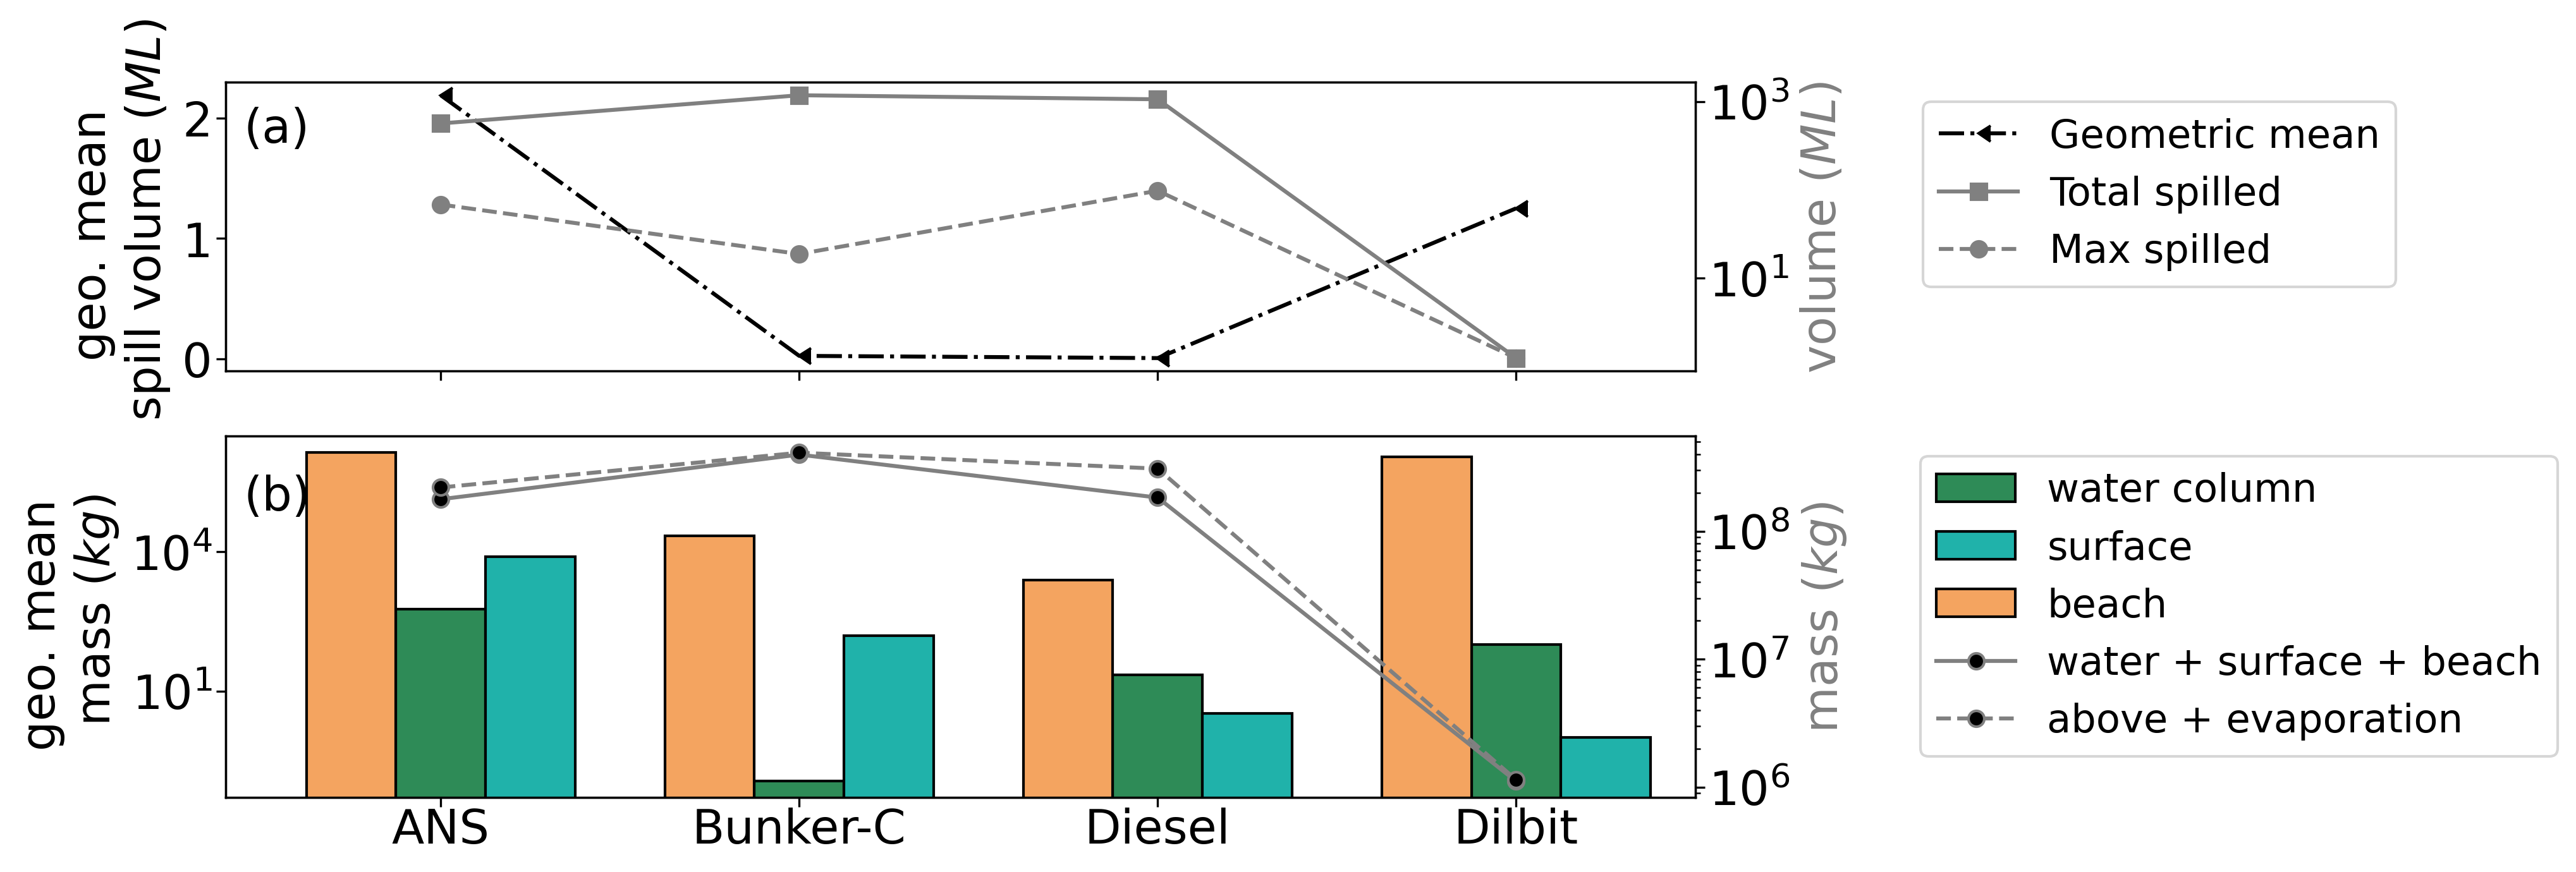

In [12]:
n=4
r = np.arange(n)
width = 0.25
# add suplot labels
subplot_labels=['(a)','(b)']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [.8,1],
                       'wspace': 0.4,
                       'hspace': 0.2})

ax[0].plot(r, geomean.values(),
           marker=4, ls="dashdot", color='black',
          label='Geometric mean')
ax0=ax[0].twinx()
ax0.plot(r, volume.values(),
           marker='s', color='grey',
          label='Total spilled')
ax0.plot(r, volume_max.values(),
           marker='o', ls="--", color='grey',
          label='Max spilled')
# get all labels into legend
lines_1, labels_1 = ax[0].get_legend_handles_labels()
lines_2, labels_2 = ax0.get_legend_handles_labels()
lines_a = lines_1 + lines_2
labels_a = labels_1 + labels_2

ax[1].bar(r, water.values(),
   width = width, edgecolor = 'black',
   color='seagreen',label='water column')
ax[1].bar(r+width, sfc.values(),
    width = width, edgecolor = 'black',
    color='lightseagreen',label='surface')
ax[1].bar(r-width, beach.values(),
    width = width, edgecolor = 'black',
    color='sandybrown',label='beach')
ax1 = ax[1].twinx()
ax1.plot(r,combined_mass.values(),
         marker='o',  markerfacecolor='black', 
         ls="solid", color='grey',
         label='water + surface + beach'
)
ax1.plot(r,total_mass.values(),
         marker='o', markerfacecolor='black', 
         ls="--", color='grey',
         label='above + evaporation'
)

lines_1, labels_1 = ax[1].get_legend_handles_labels()
lines_2, labels_2 = ax1.get_legend_handles_labels()
lines_b = lines_1 + lines_2
labels_b = labels_1 + labels_2


# subplot labels
ax[0].text(-0.55,1.8,'(a)')
ax[1].text(-0.55,8e4,'(b)')
# axis scales
ax0.set_yscale('log')
ax[1].set_yscale('log')
ax1.set_yscale('log')
# ylabels and axes
#ax[0].set_ylim(1,5e3)
ax[0].set_ylabel('geo. mean \n spill volume ($ML$)')
ax0.set_ylabel('volume ($ML$)')
ax[1].set_ylabel("geo. mean \n mass ($kg$)")
ax1.set_ylabel('mass ($kg$)')
ax[1].set_xticks(r)
ax0.yaxis.label.set_color('grey') 
ax1.yaxis.label.set_color('grey') 
#ax0.yaxis.set_color('grey') 
#ax1.yaxis.set_color('grey') 
# xlabels and axes
ax[0].set_xticks(r)
ax[0].set_xlim(-0.6, 3.5)
ax[1].set_xlim(-0.6, 3.5)
ax[0].set_xticklabels('')
ax[1].set_xticklabels(oil_types)
# legends
ax[0].legend(lines_a, labels_a, bbox_to_anchor=(1.49, 1), loc='upper right')
#ax[1].set_title('Geometric mean across spills of oil masses at final timestep')
ax[1].legend(lines_b, labels_b, bbox_to_anchor=(1.6, 1),loc='upper right')

plt.savefig(graphics_dir/'massByOil_withDilbit.png')

## Above without dilbit

In [13]:
# remove dilbit
geomean.pop('Dilbit')
volume.pop('Dilbit')
volume_max.pop('Dilbit')
water.pop('Dilbit')
sfc.pop('Dilbit')
beach.pop('Dilbit')
combined_mass.pop('Dilbit')
total_mass.pop('Dilbit')

1142441.0483756834

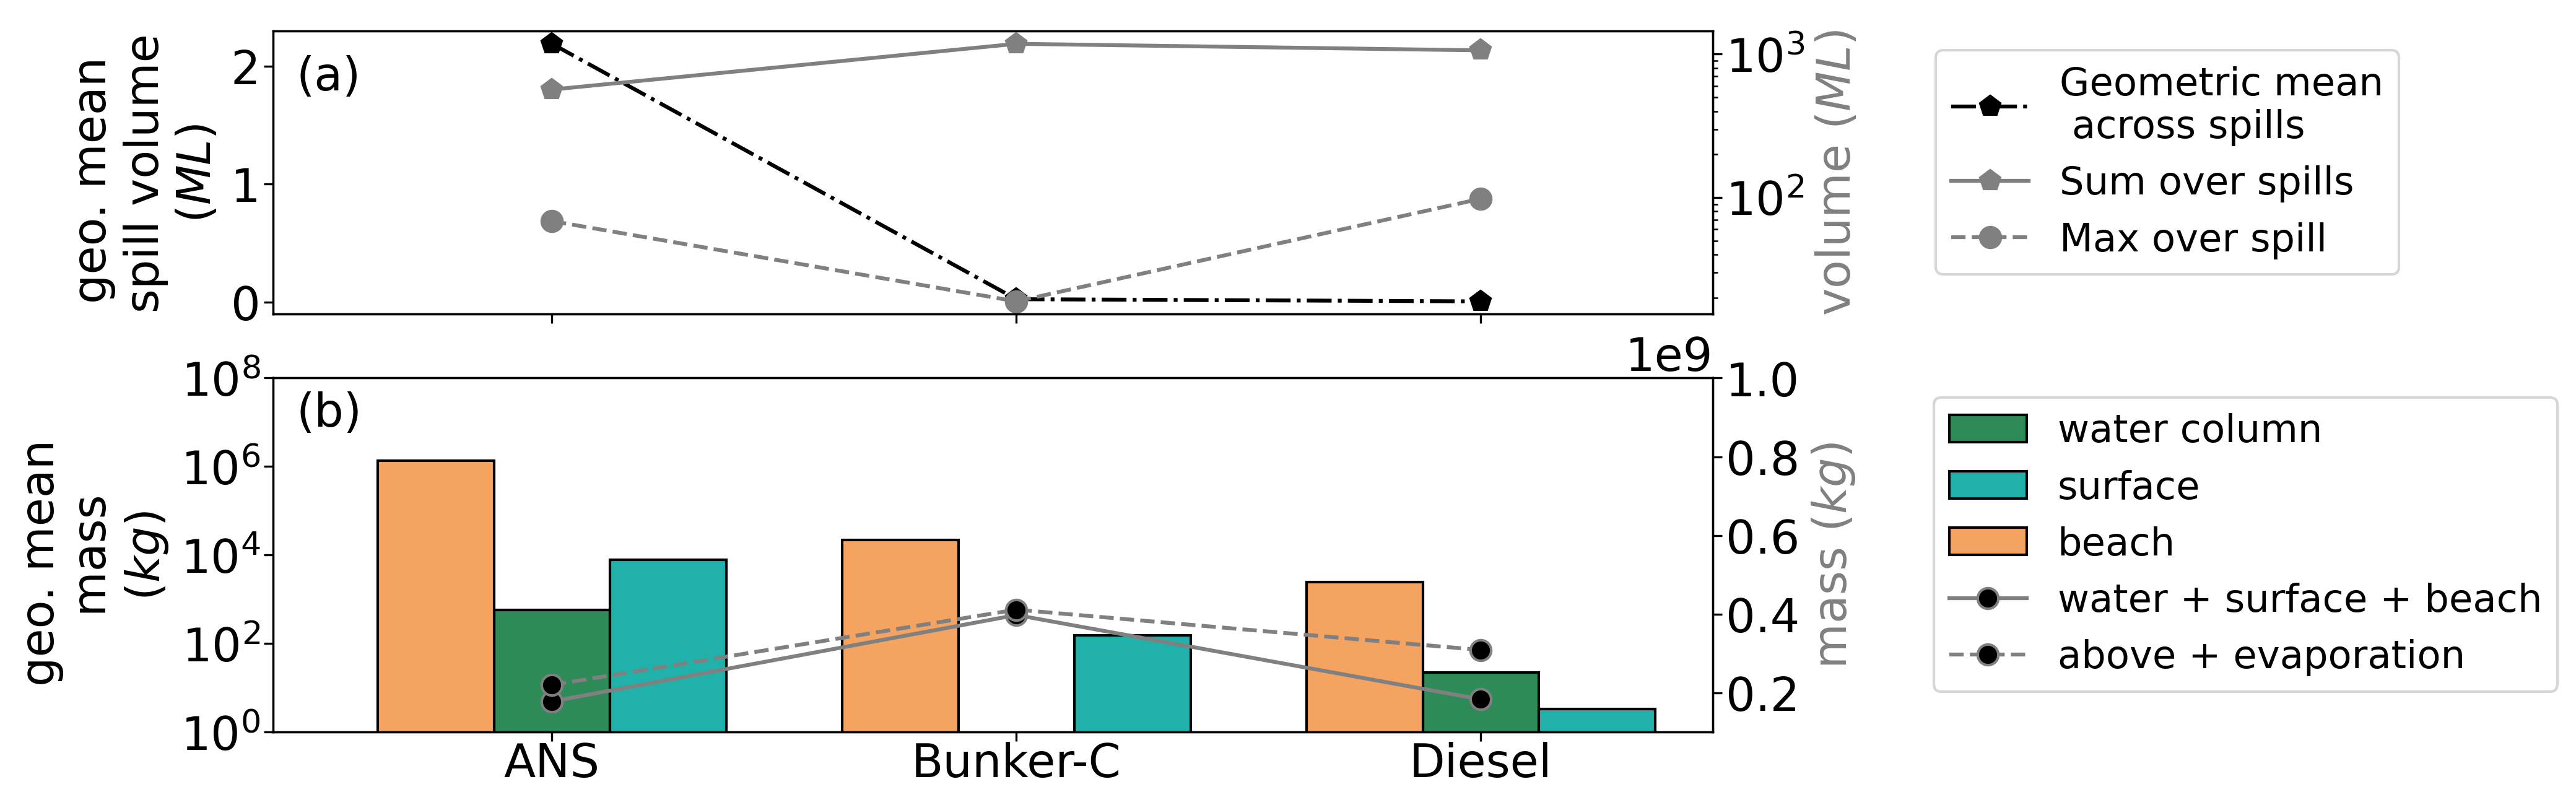

In [14]:
plt.style.use(r"../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")
# plot                            
n=3
r = np.arange(n)
width = 0.25
# add suplot labels
subplot_labels=['(a)','(b)']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [.8,1],
                       'wspace': 0.4,
                       'hspace': 0.2})
# ~~~  (a) spill volumes from spills file ~~~
ax[0].plot(r, geomean.values(),
           marker='p', 
           markersize=8,
           ls="dashdot", color='black',
          label='Geometric mean\n across spills')
ax0=ax[0].twinx()
ax0.plot(r, volume.values(),
           marker='p', 
         markersize=8,
         color='grey',
          label='Sum over spills')
ax0.plot(r, volume_max.values(),
           marker='o', 
         markersize=8,
         ls="--", color='grey',
          label='Max over spill')
# get all labels into legend
lines_1, labels_1 = ax[0].get_legend_handles_labels()
lines_2, labels_2 = ax0.get_legend_handles_labels()
lines_a = lines_1 + lines_2
labels_a = labels_1 + labels_2

# ~~~  (b) mass balance from .sro output ~~~
ax[1].bar(r, water.values(),
   width = width, edgecolor = 'black',
   color='seagreen',label='water column')
ax[1].bar(r+width, sfc.values(),
    width = width, edgecolor = 'black',
    color='lightseagreen',label='surface')
ax[1].bar(r-width, beach.values(),
    width = width, edgecolor = 'black',
    color='sandybrown',label='beach')
ax1 = ax[1].twinx()
ax1.plot(r,combined_mass.values(),
         markersize=8,
         marker='o',markerfacecolor='black',
         ls="solid",color='grey',
         label='water + surface + beach'
)
ax1.plot(r,total_mass.values(),
         markersize=8,
         marker='o',markerfacecolor='black',
         ls="--",color='grey',
         label='above + evaporation'
)

lines_1, labels_1 = ax[1].get_legend_handles_labels()
lines_2, labels_2 = ax1.get_legend_handles_labels()
lines_b = lines_1 + lines_2
labels_b = labels_1 + labels_2


# subplot labels
ax[0].text(-0.55,1.8,'(a)')
ax[1].text(-0.55,8e6,'(b)')
# axis scales
ax0.set_yscale('log')
ax[1].set_yscale('log')
ax1.set_yscale('linear')
# ylabels and axes
#ax[0].set_ylim(1,5e3)
ax[0].set_ylabel('geo. mean \n spill volume \n($ML$)')
ax0.set_ylabel('volume ($ML$)')
ax[1].set_ylim(1e0, 1e7)
ax[1].set_yticks([1e0, 1e2, 1e4, 1e6, 1e8])
ax1.set_ylim(1e8, 10e8)
ax1.set_yticks([2e8, 4e8, 6e8, 8e8, 10e8])
ax[1].set_ylabel("geo. mean \n mass \n($kg$)")
ax1.set_ylabel('mass ($kg$)')
ax[1].set_xticks(r)
ax0.yaxis.label.set_color('grey') 
ax1.yaxis.label.set_color('grey') 
#ax0.yaxis.set_color('grey') 
#ax1.yaxis.set_color('grey') 
# xlabels and axes
ax[0].set_xticks(r)
ax[0].set_xlim(-0.6, 2.5)
ax[1].set_xlim(-0.6, 2.5)
ax[0].set_xticklabels('')
ax[1].set_xticklabels(oil_types[:3])
# legends
ax[0].legend(lines_a, labels_a, bbox_to_anchor=(1.49, 1), loc='upper right')
#ax[1].set_title('Geometric mean across spills of oil masses at final timestep')
ax[1].legend(lines_b, labels_b, bbox_to_anchor=(1.6, 1),loc='upper right')

plt.savefig(graphics_dir/'massByOil.png')



## Create metric for demonstrating persistence

#### initial
- MBeached = (data['VolOilBeached'][1].item()*data['Density'][1].item()/
     (1-data['VWaterContent'][1].item())*
     (1-data['MWaterContent'][1].item()))
- MInitial= data['MEvaporated'][1].item() + data['MDispersed'][1].item() + 
    data['MDissolved'][1].item() + data['MBio'][1].item() + 
    data['MassOil'][1].item() + MBeached
#### final (remove values associated with bogus dissolution/evaporation/surface)
- water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0] 

#### Print out persist values for debugging

In [15]:
# median value of the final mass (by category) over initial spill
locations = ['water','sfc','beach','air']
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
for oil in ['ANS','Bunker-C','Diesel']:
    print('~~~~~~')
    print(f'{oil}')
    print('~~~~~~')
    for location in locations:
        print(f'*** {location} ***')
        pers_tmp = final[location][oil]/(initial[oil])
        print(pers_tmp.loc[pers_tmp>=1])
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~
ANS
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
Series([], dtype: float64)
*** air ***
Series([], dtype: float64)
~~~~~~
Bunker-C
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
34      1.000485
54      1.000549
59      1.001854
105     1.000560
142     1.000670
166     1.001409
172     1.000035
188     1.000042
197     1.000066
220     1.000044
295     1.000039
315     1.000472
345     1.000388
380     1.001263
484     1.000174
490     1.000028
491     1.001405
557     1.000562
574     1.000196
579     1.000194
601     1.000893
611     1.000078
675     1.000786
686     1.000556
688     1.000436
689     1.000245
708     1.000464
781     1.001338
815     1.000269
849     1.000011
863     1.000269
865     1.000057
871     1.000857
877     1.000989
940     1.000002
941     1.000114
942     1.000106
1001    

#### take-away: Bunker beaching values are wonky.  Perhaps a reflection of the evaporation error that is now fixed.  

### Create dataframes of values for:
- median
- mean
- stdev
- min
- max
- quantiles (0.25, 0.50, 0.75)

In [16]:
locations = ['water','sfc','beach','air']
opperations = ['median','mean','std','min','max']
job='median'
getattr(numpy, job)([0, 2, 3])
#numpy.median([0, 2, 3])
persist = {}

# Calculate Quantiles
persist['Q1']={}
persist['Q2']={}
persist['Q3']={}
for oil in ['ANS','Bunker-C','Diesel']:
    persist['Q1'][oil]={}
    persist['Q2'][oil]={}
    persist['Q3'][oil]={}
    for loc in locations:
        #Quantile 0.25
        persist['Q1'][oil][loc]=numpy.quantile(
            final[loc][oil]/(initial[oil]), .25)
        #Quantile 0.5 (median)
        persist['Q2'][oil][loc]=numpy.quantile(
            final[loc][oil]/(initial[oil]), .50)
        #Quantile 0.75
        persist['Q3'][oil][loc]=numpy.quantile(
            final[loc][oil]/(initial[oil]), .75)

# Calculate other stats across persistence fractions
print('Calculating the following stats across persistence fraction')
for opp in opperations:
    print("|_", opp)
    persist[opp]={}  
    for oil in ['ANS','Bunker-C','Diesel']:
        print("    |_", oil)
        persist[opp][oil]={}
        for loc in locations:
            print("        |_", loc)
            # median value of the final mass (by category) over initial spill
            persist[opp][oil][loc]=getattr(numpy, opp)(
                final[loc][oil]/(initial[oil])
            )
# Add Quantiles to opperations
opperations = ['median','mean','std','min','max','Q1','Q2','Q3']
persist_df={}
print('-------------------')
print('BUILDING DATAFRAMES')
print('-------------------')
for opp in opperations:
    print('\n\n \_ ', opp)
    persist_df[opp] = pd.DataFrame({
        "ANS":[persist[opp]["ANS"]["water"], persist[opp]["ANS"]["sfc"], persist[opp]["ANS"]["beach"], persist[opp]["ANS"]["air"]],
        "Bunker-C":[persist[opp]["Bunker-C"]["water"], persist[opp]["Bunker-C"]["sfc"], persist[opp]["Bunker-C"]["beach"], persist[opp]["Bunker-C"]["air"]],
        "Diesel":[persist[opp]["Diesel"]["water"], persist[opp]["Diesel"]["sfc"], persist[opp]["Diesel"]["beach"], persist[opp]["Diesel"]["air"]]
        }, 
        index=["water", "surface", "beach", "air"]
    )
    persist_df[opp] = persist_df[opp].rename_axis(opp, axis=1)
    print(persist_df[opp])   

Calculating the following stats across persistence fraction
|_ median
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ mean
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ std
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ min
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        

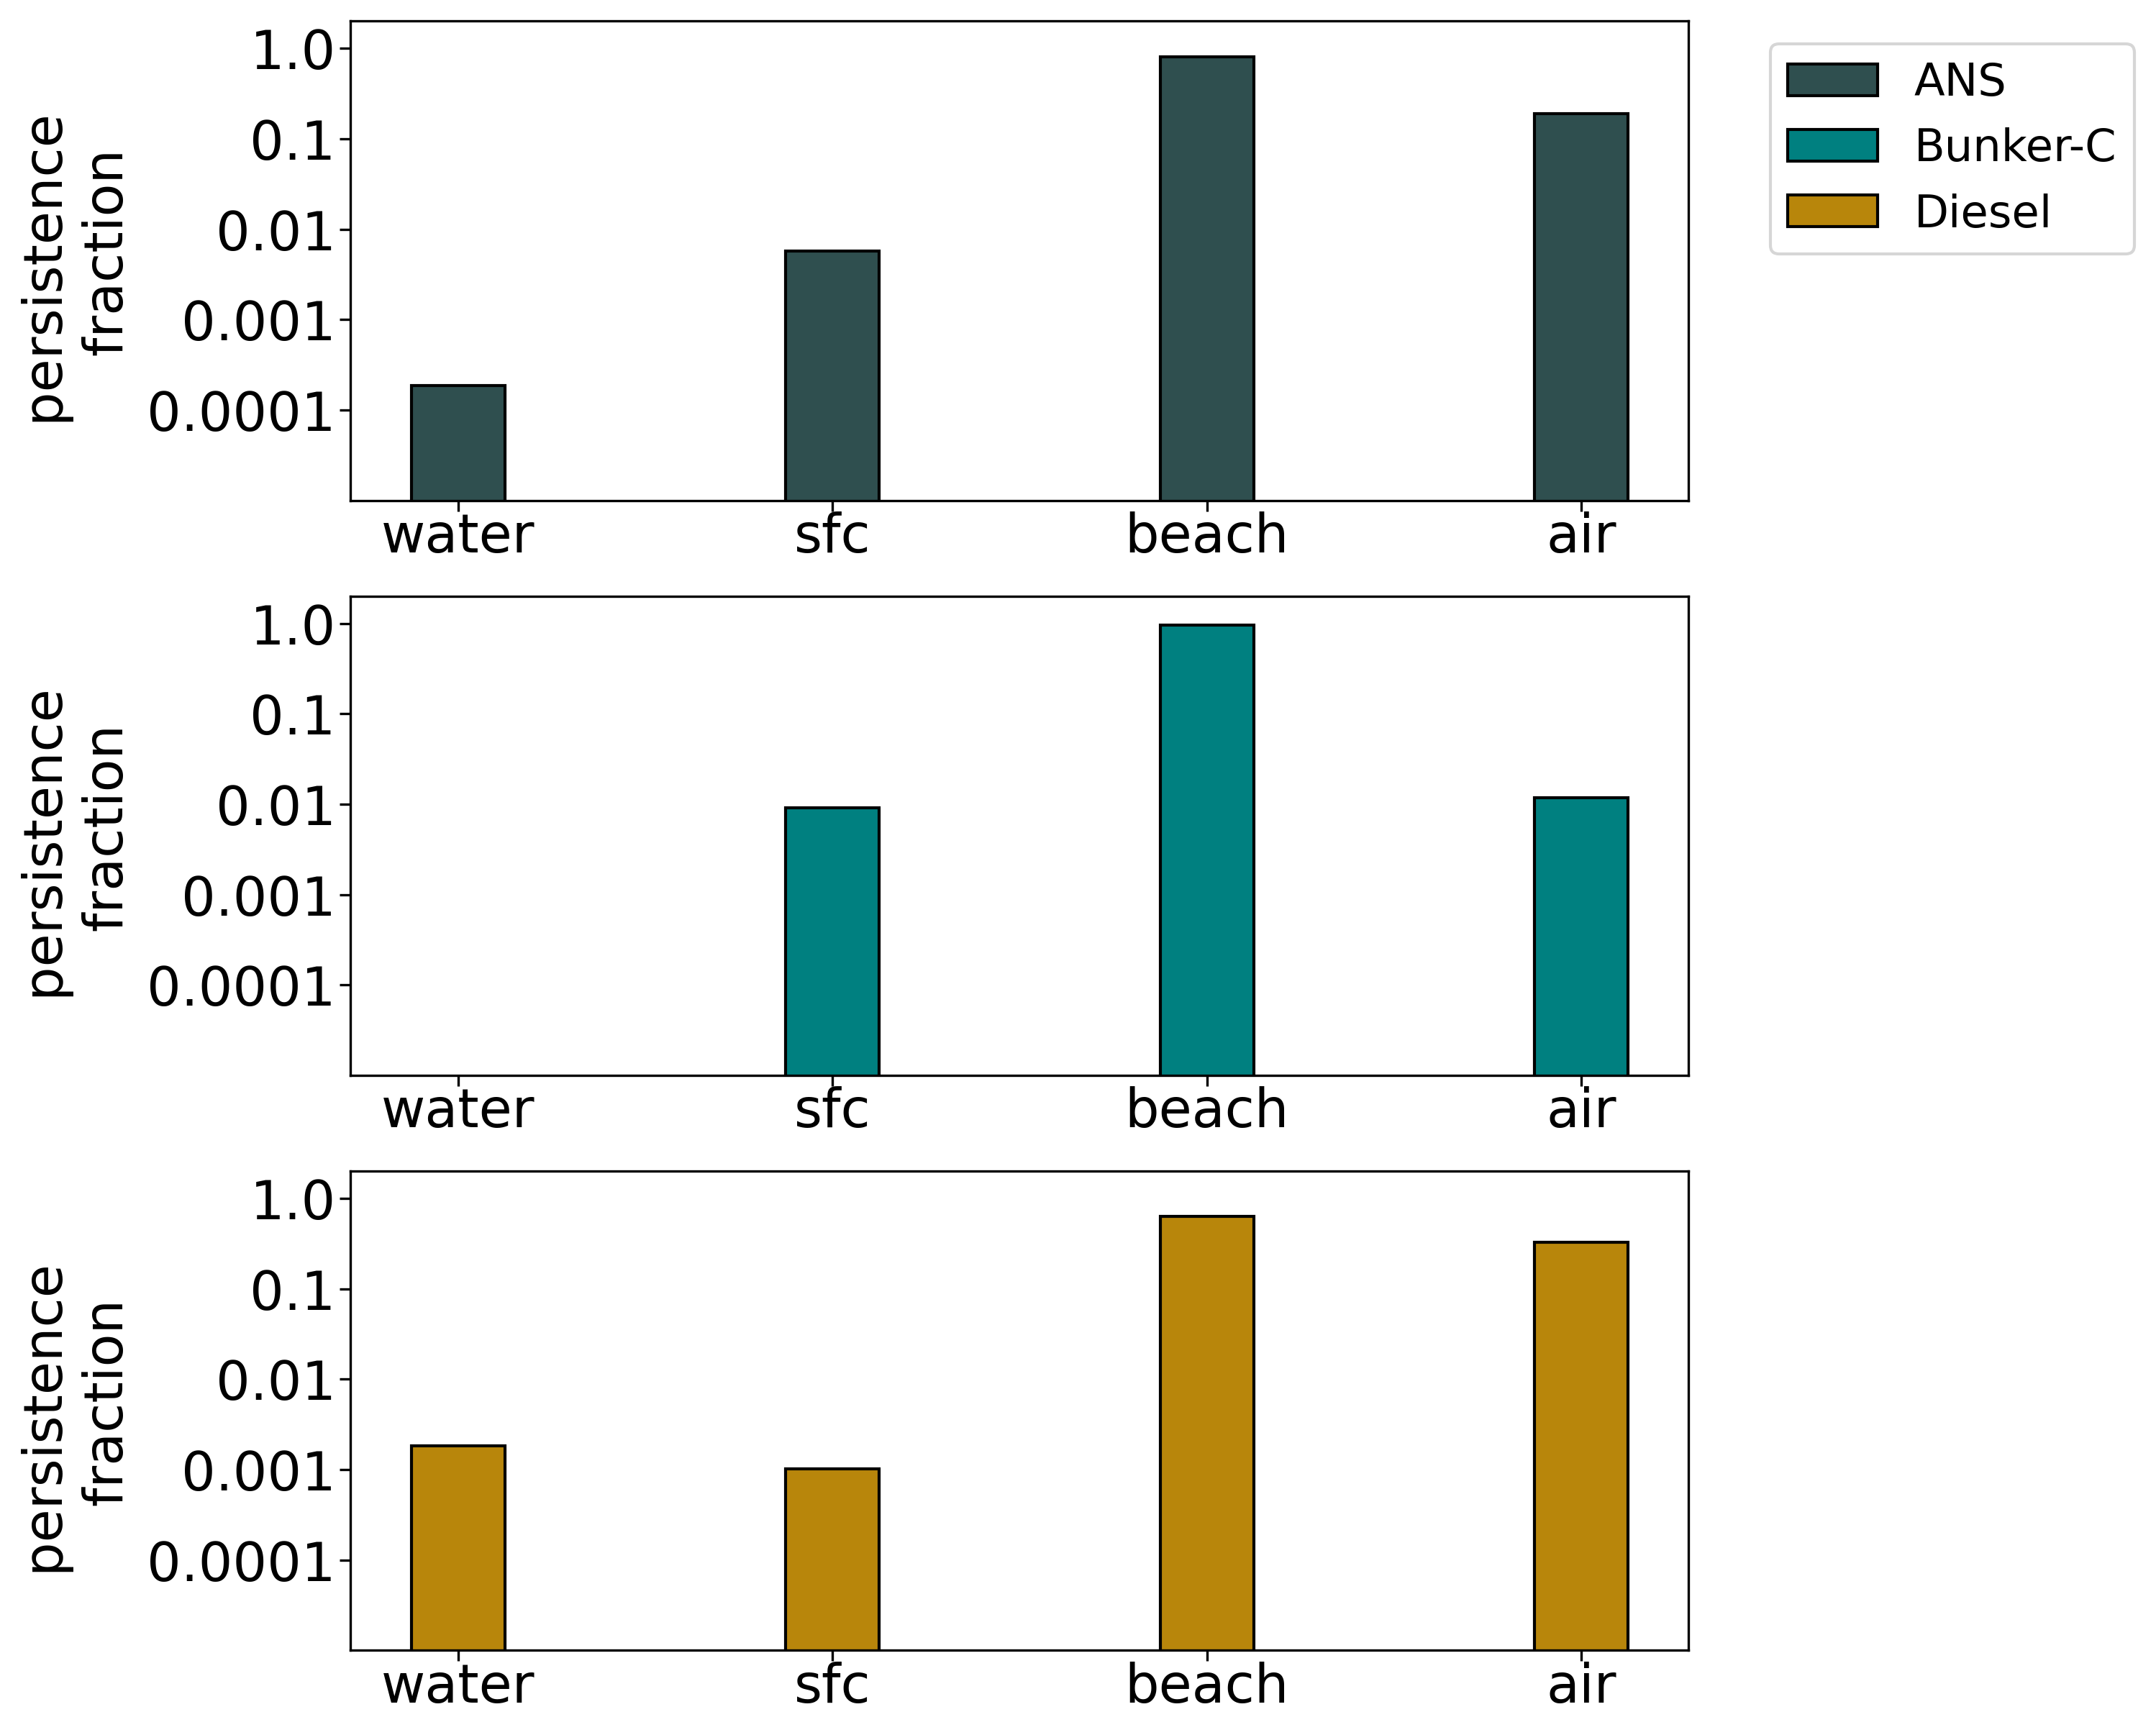

In [17]:
n=4
r = np.arange(n)
width = 0.25
# add suplot labels
subplot_labels=['(a)','(b)']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 10),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1,1,1],
                       'wspace': 0.4,
                       'hspace': 0.2})
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax[idx].bar(r, persist['median'][oil].values(),
       width = width, edgecolor = 'black',
       color=MIDOSScolors[oil],label=oil)
    # axis scales
    ax[idx].set_yscale('log')
    # ylabels and axes
    ax[idx].set_ylabel('persistence \n fraction')
    ax[idx].set_ylim(1e-5, 2e0)
    ax[idx].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax[idx].set_yticklabels([0.0001, 0.001, 0.01, 0.1, 1.0])
    ax[idx].set_xticks(r) 
    # xlabels and axes
    ax[idx].set_xticklabels(locations)
    lines_sub, labels_sub = ax[idx].get_legend_handles_labels()
    if idx==0:
        lines=lines_sub
        labels=labels_sub
    else:
        lines+=lines_sub
        labels+=labels_sub
ax[0].legend(lines, labels, bbox_to_anchor=(1.35, 1), loc='upper right')

plt.savefig(graphics_dir/'persistence.png')



In [18]:
plotdata = pd.DataFrame({
    "ANS":[persist['median']["ANS"]["water"], persist['median']["ANS"]["sfc"], persist['median']["ANS"]["beach"], persist['median']["ANS"]["air"]],
    "Bunker-C":[persist['median']["Bunker-C"]["water"], persist['median']["Bunker-C"]["sfc"], persist['median']["Bunker-C"]["beach"], persist['median']["Bunker-C"]["air"]],
    "Diesel":[persist['median']["Diesel"]["water"], persist['median']["Diesel"]["sfc"], persist['median']["Diesel"]["beach"], persist['median']["Diesel"]["air"]]
    }, 
    index=["water\ncolumn", "water\nsurface", "beach", "air"]
)
plotdata

,ANS,Bunker-C,Diesel
water\ncolumn,0.000187,0.000001,0.001843
water\nsurface,0.005754,0.009200,0.001018
beach,0.805597,0.958212,0.632557
air,0.187903,0.011854,0.328364


In [19]:
persist_df['median']

median,ANS,Bunker-C,Diesel
water,0.000187,0.000001,0.001843
surface,0.005754,0.009200,0.001018
beach,0.805597,0.958212,0.632557
air,0.187903,0.011854,0.328364


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


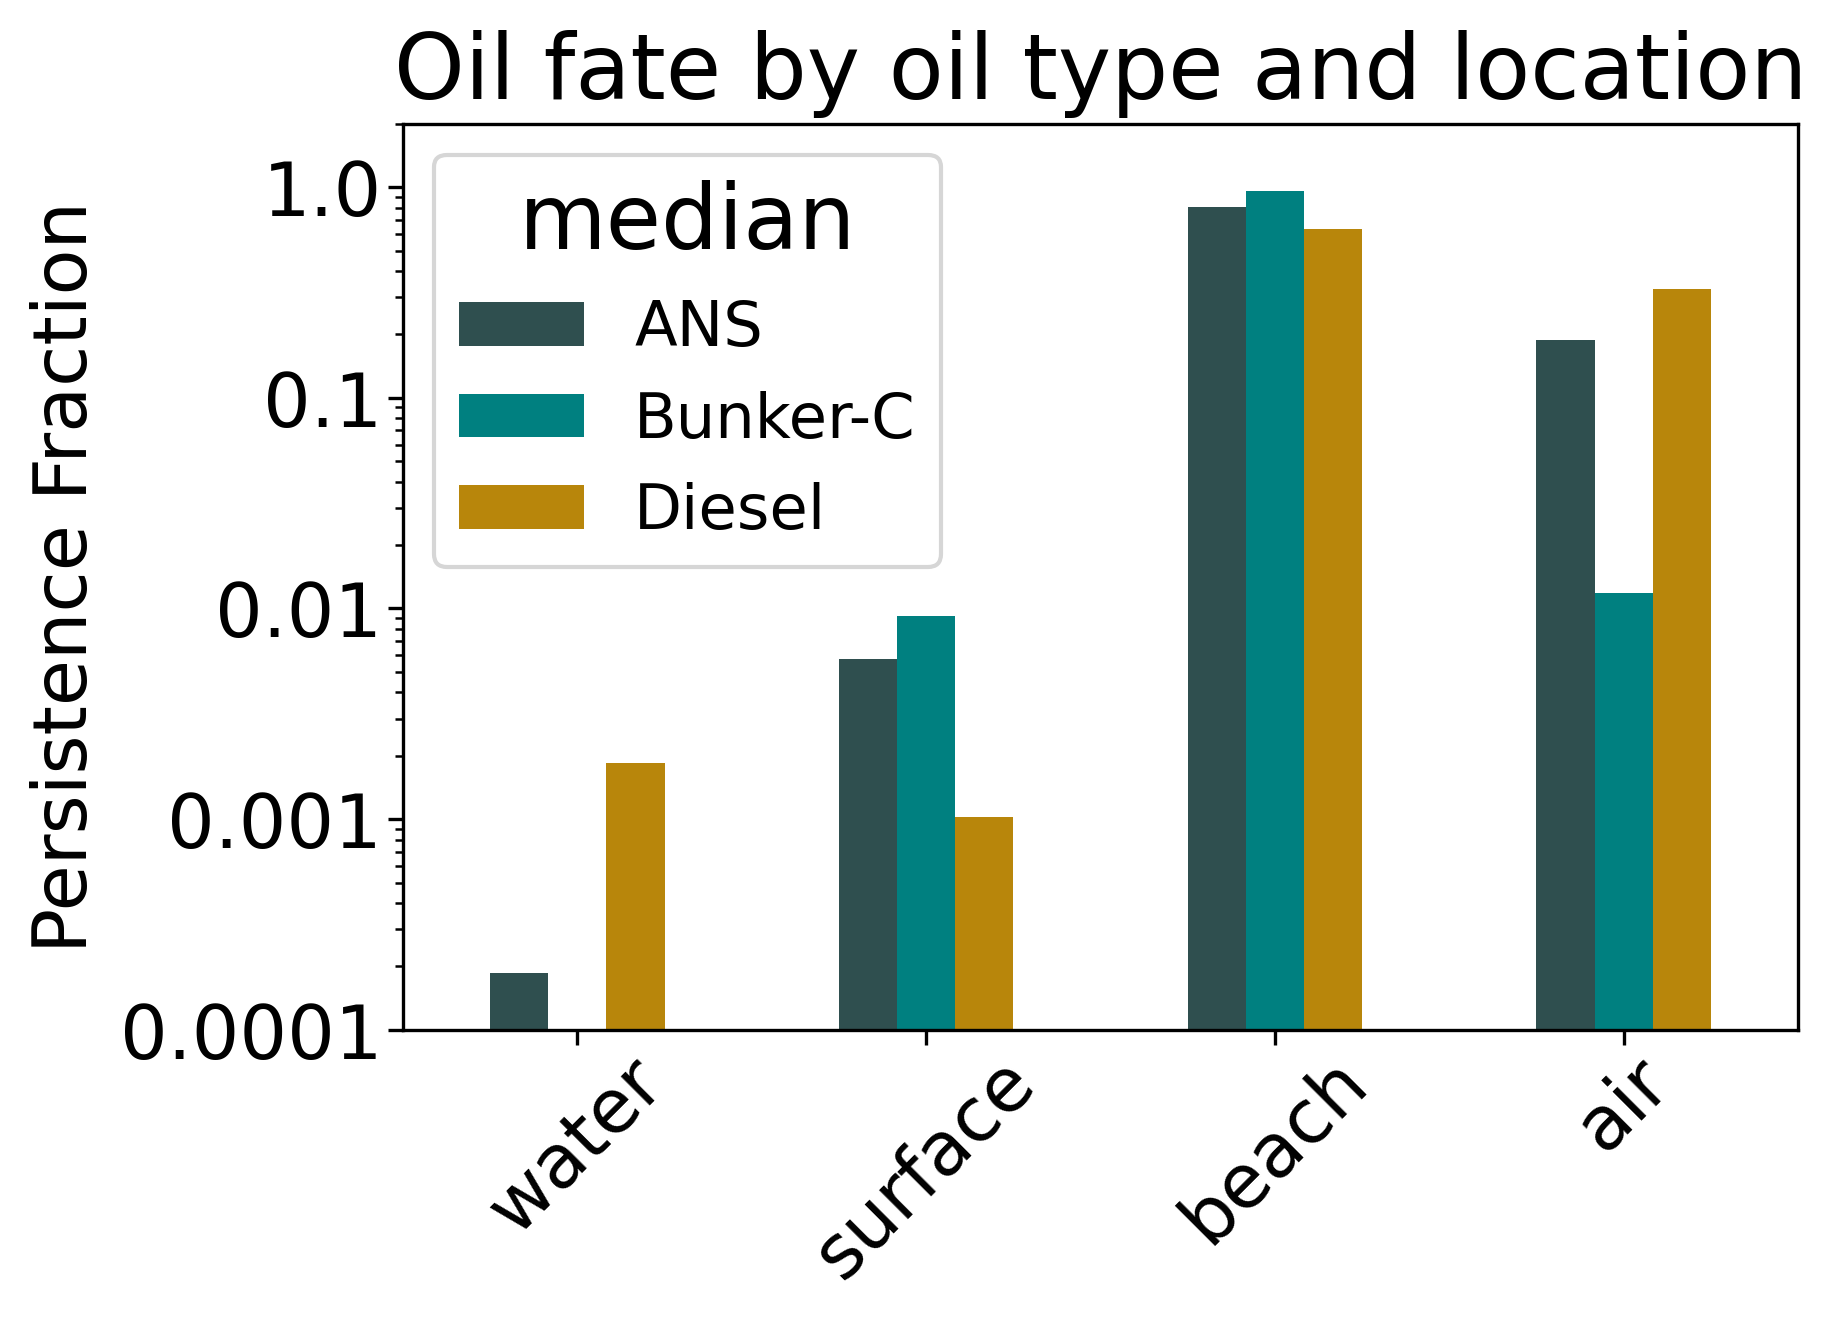

In [20]:

ax=persist_df['median'].plot(
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],)
plt.title("Oil fate by oil type and location")
#plt.xlabel("Location of oil")
plt.xticks(rotation=45)
plt.ylabel("Persistence Fraction")
plt.yscale("log")
plt.ylim(1e-4,2e0)
plt.yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels([0.0001, 0.001, 0.01, 0.1, 1.0])
plt.savefig(graphics_dir/'persistence_1panel_log.png')



### create error bars from Quantiles

In [21]:
error_min = [[persist['Q1']["ANS"]["water"],persist['Q1']["ANS"]["sfc"],persist['Q1']["ANS"]["beach"],persist['Q1']["ANS"]["air"]],
         [persist['Q1']["Bunker-C"]["water"],persist['Q1']["Bunker-C"]["sfc"],persist['Q1']["Bunker-C"]["beach"],persist['Q1']["Bunker-C"]["air"]],
         [persist['Q1']["Diesel"]["water"],persist['Q1']["Diesel"]["sfc"],persist['Q1']["Diesel"]["beach"],persist['Q1']["Diesel"]["air"]]
]

error_max = [[persist['Q3']["ANS"]["water"],persist['Q3']["ANS"]["sfc"],persist['Q3']["ANS"]["beach"],persist['Q3']["ANS"]["air"]],
         [persist['Q3']["Bunker-C"]["water"],persist['Q3']["Bunker-C"]["sfc"],persist['Q3']["Bunker-C"]["beach"],persist['Q3']["Bunker-C"]["air"]],
         [persist['Q3']["Diesel"]["water"],persist['Q3']["Diesel"]["sfc"],persist['Q3']["Diesel"]["beach"],persist['Q3']["Diesel"]["air"]]
]
# minimum
mindf = pd.DataFrame(numpy.transpose(error_min))
mindf=mindf.rename(
    columns={0:'ANS',1:'Bunker-C',2:'Diesel'},
    index={0:"water\ncolumn", 1:"water\nsurface", 2:"beach", 3:"air"}
)
# maximum
maxdf = pd.DataFrame(numpy.transpose(error_max))
maxdf=maxdf.rename(
    columns={0:'ANS',1:'Bunker-C',2:'Diesel'},
    index={0:"water\ncolumn", 1:"water\nsurface", 2:"beach", 3:"air"}
)
error_df={}
error_df['min']=plotdata-mindf
error_df['max']=maxdf-plotdata
error_min = [error_df['min']['ANS'].to_list(),error_df['min']['Bunker-C'].to_list(),error_df['min']['Diesel'].to_list()]
error_max = [error_df['max']['ANS'].to_list(),error_df['max']['Bunker-C'].to_list(),error_df['max']['Diesel'].to_list()]

### print Bunker-C values 

In [22]:
print('Bunker-C:\n \t Beaching median: ', persist['median']['Bunker-C']['beach'])
print('\t Quantile 0.25: ', persist['Q1']['Bunker-C']['beach'])
print('\t Quantile 0.50: ', persist['Q2']['Bunker-C']['beach'])
print('\t Quantile 0.75: ', persist['Q3']['Bunker-C']['beach'])

Bunker-C:
 	 Beaching median:  0.9582124839882459
	 Quantile 0.25:  0.8562567040291088
	 Quantile 0.50:  0.9582124839882459
	 Quantile 0.75:  0.9927775046098771


In [23]:
error_df

{'min':                      ANS  Bunker-C    Diesel
 water\ncolumn   0.000067  0.000001  0.001276
 water\nsurface  0.004271  0.008719  0.000937
 beach           0.031316  0.101956  0.197157
 air             0.011746  0.011854  0.101441,
 'max':                      ANS  Bunker-C    Diesel
 water\ncolumn   0.000493  0.000042  0.043751
 water\nsurface  0.023525  0.083343  0.007954
 beach           0.013539  0.034565  0.127226
 air             0.013124  0.040362  0.112409}

In [24]:
yerr=np.append(error_min,error_max, axis=0)
yerr

array([[6.69744288e-05, 4.27131747e-03, 3.13163776e-02, 1.17458229e-02],
       [1.18544786e-06, 8.71882908e-03, 1.01955780e-01, 1.18542679e-02],
       [1.27599696e-03, 9.37273734e-04, 1.97156811e-01, 1.01440719e-01],
       [4.93247401e-04, 2.35248444e-02, 1.35385672e-02, 1.31239182e-02],
       [4.23930479e-05, 8.33432378e-02, 3.45650206e-02, 4.03615522e-02],
       [4.37506471e-02, 7.95443542e-03, 1.27226442e-01, 1.12409368e-01]])

In [25]:
# reorganize that above array so that it's in order of:
# Row1: ANS min error
# Row2: ANS max error
# Row3: Bunker min error
# Row4: Bunker max error
# Row5: Diesel min error
# Row6: Diesel max error
yerr_reorg = np.array([[6.69744288e-05, 4.27131747e-03, 3.13163776e-02, 1.17458229e-02],
                       [4.93247401e-04, 2.35248444e-02, 1.35385672e-02, 1.31239182e-02],
                       [1.18544786e-06, 8.71882908e-03, 1.01955780e-01, 1.18542679e-02],
                       [4.23930479e-05, 8.33432378e-02, 3.45650206e-02, 4.03615522e-02],
                       [1.27599696e-03, 9.37273734e-04, 1.97156811e-01, 1.01440719e-01],
                       [4.37506471e-02, 7.95443542e-03, 1.27226442e-01, 1.12409368e-01]])

##### The first three rows are min error for ANS, Bunker-C, Diesel
##### The last three rows are the max error for the same

In [26]:
persist_df['median']

median,ANS,Bunker-C,Diesel
water,0.000187,0.000001,0.001843
surface,0.005754,0.009200,0.001018
beach,0.805597,0.958212,0.632557
air,0.187903,0.011854,0.328364


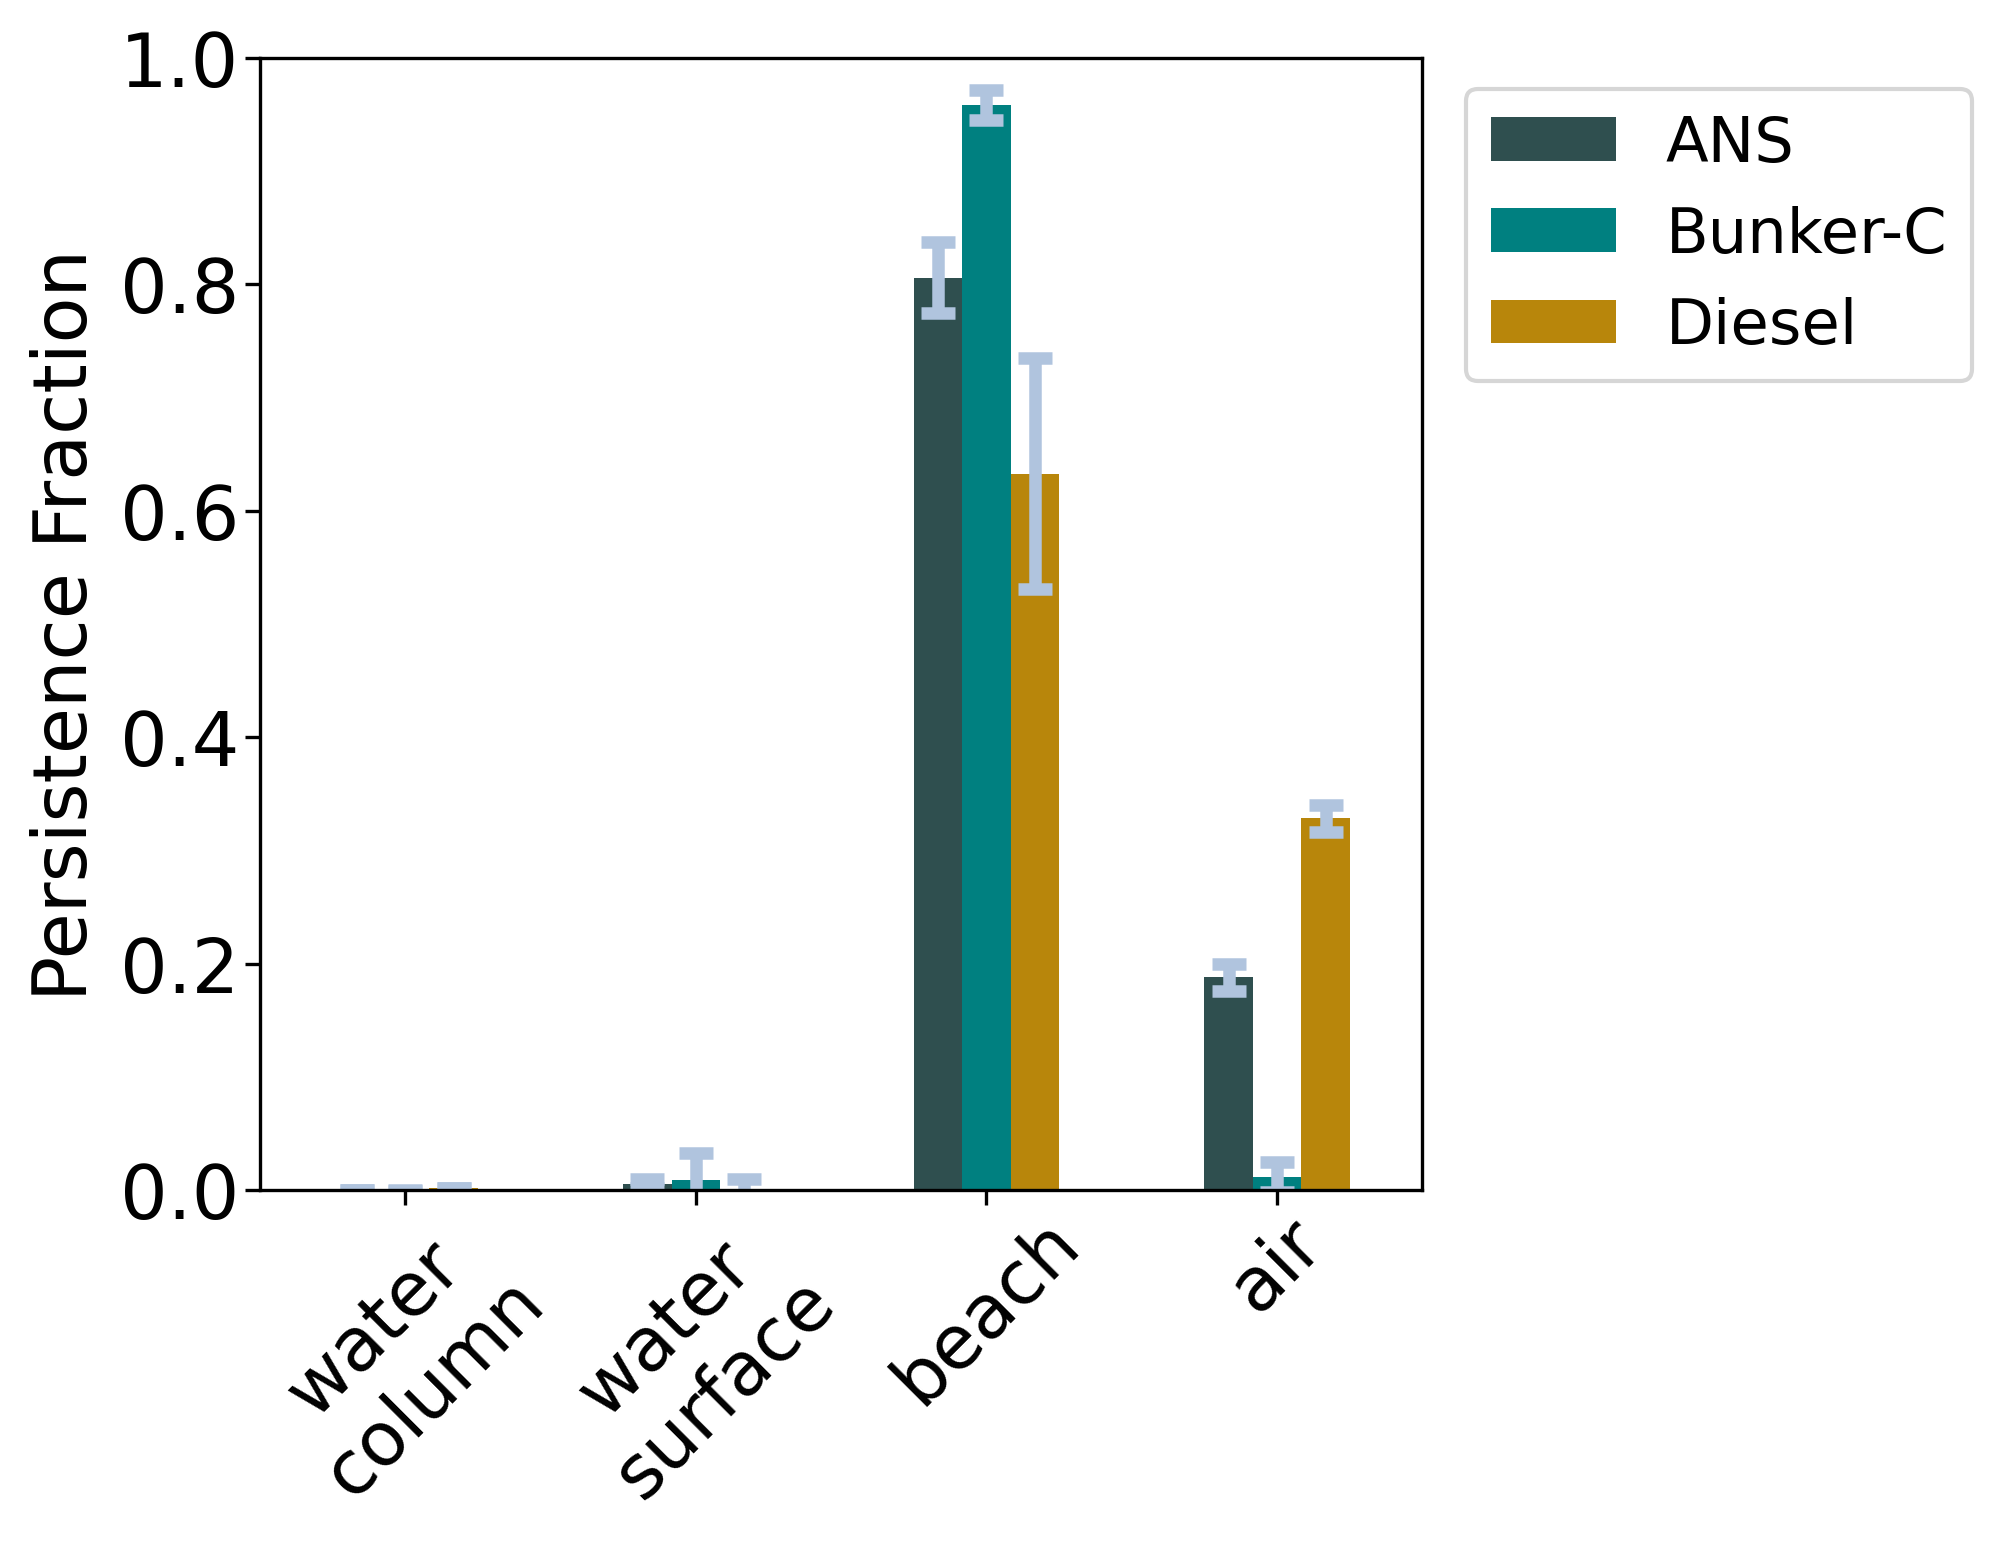

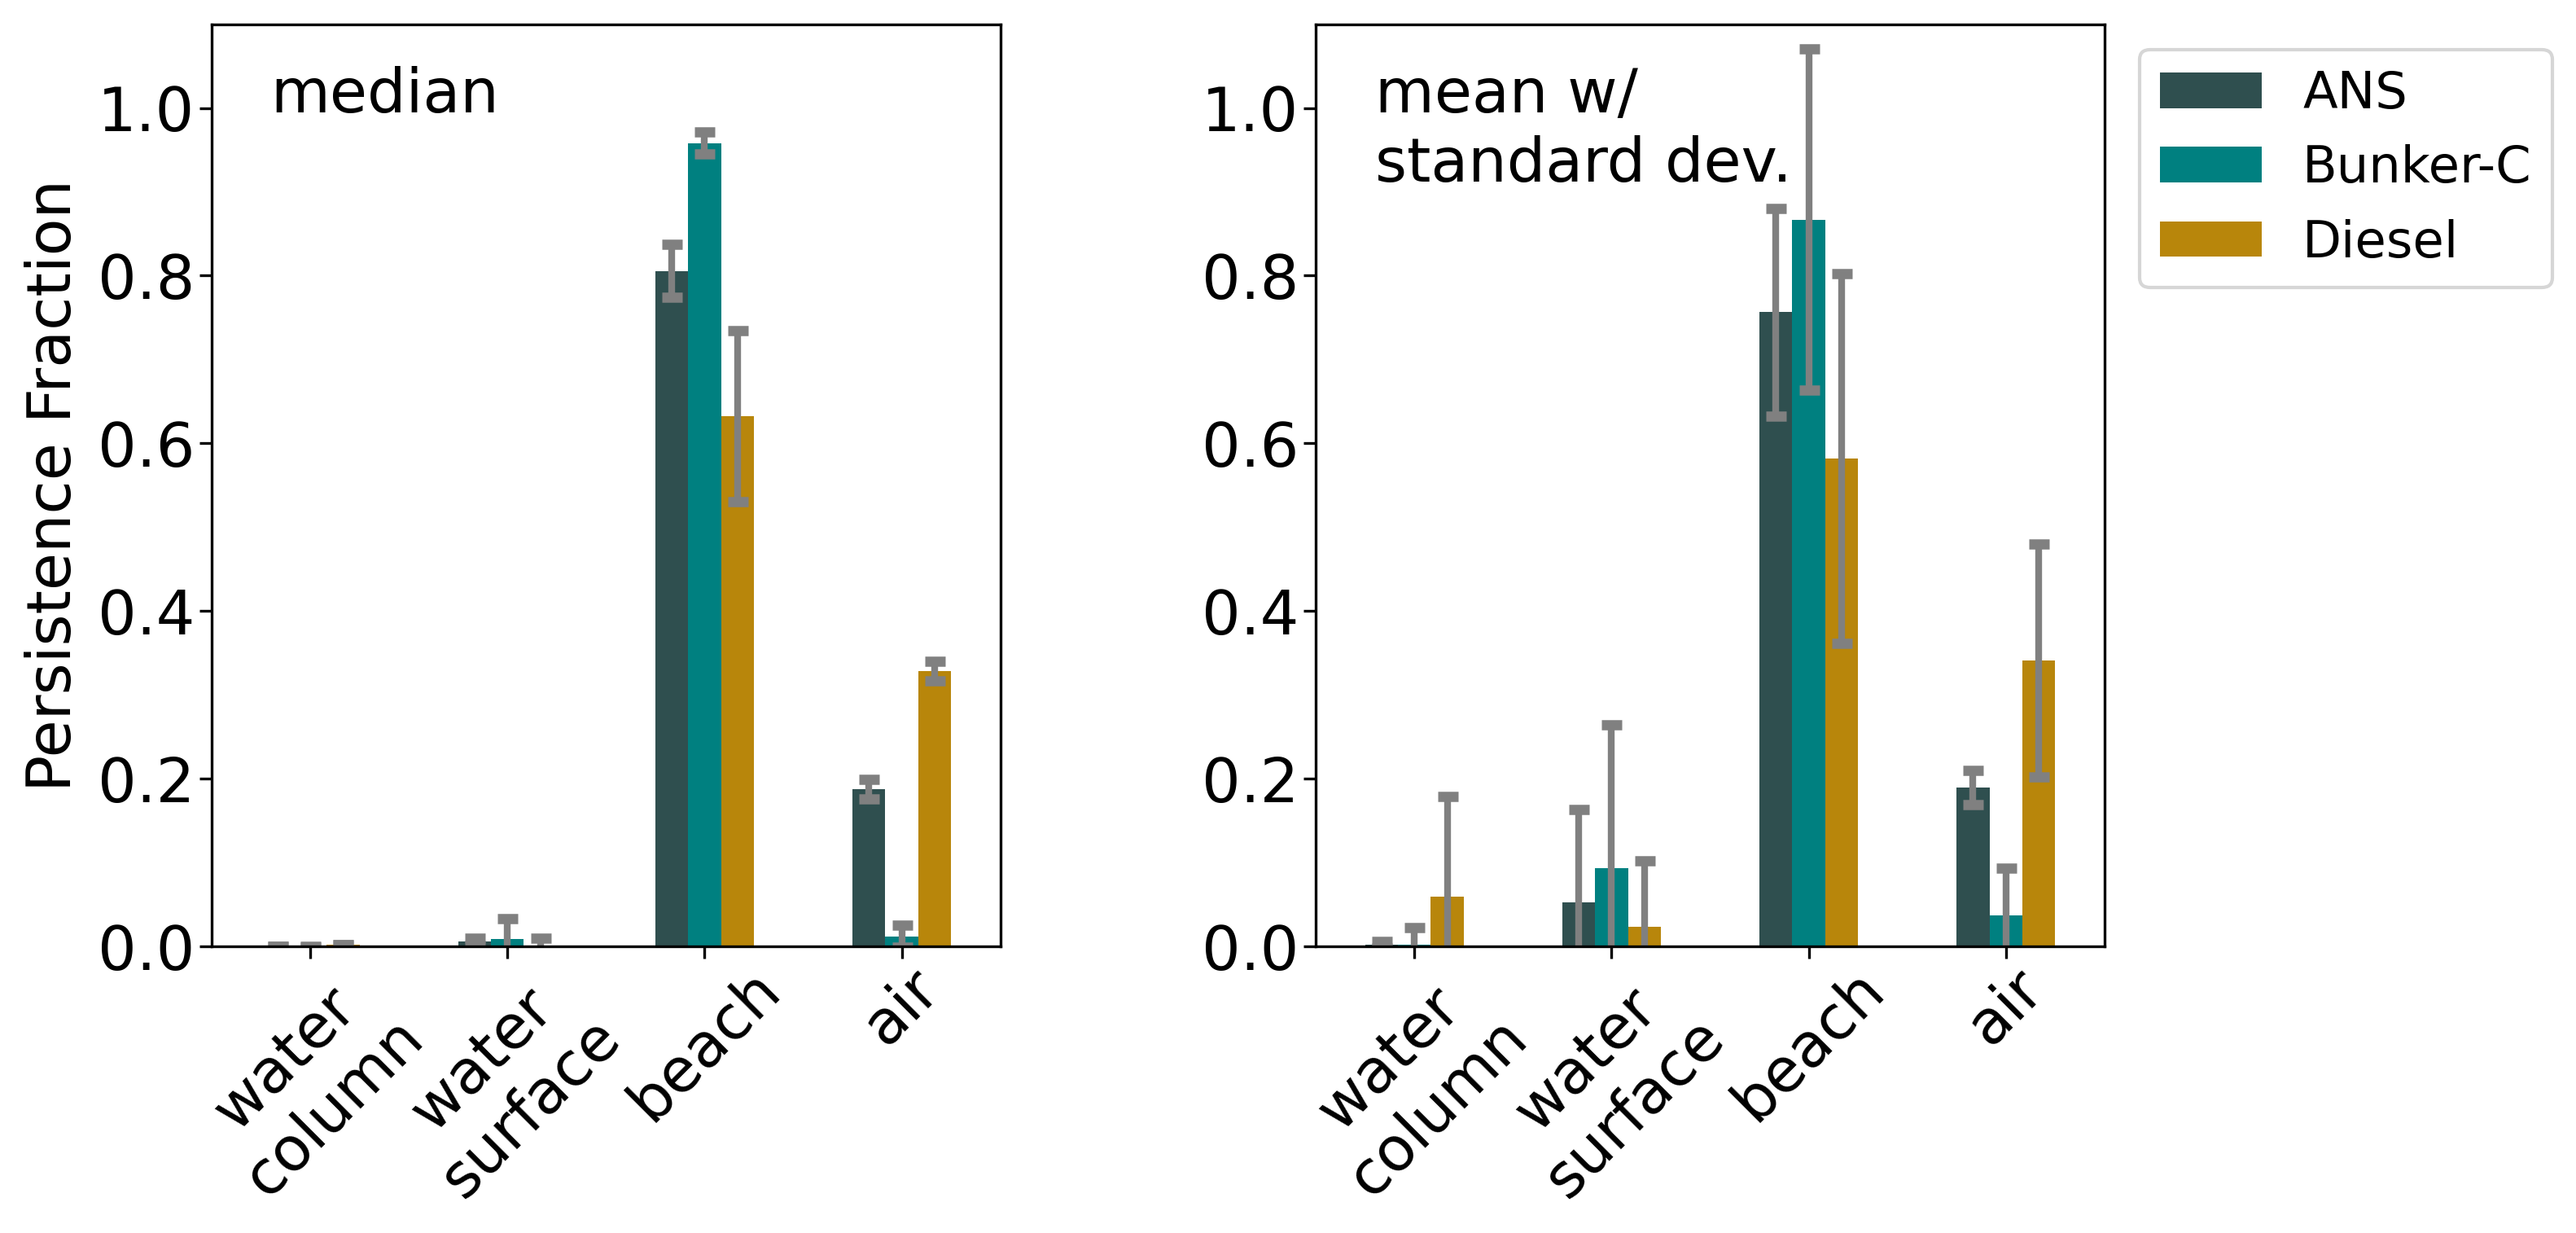

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax,
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    legend=False,          
    yerr=yerr_reorg, #np.append(error_max, error_min, axis=0), 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Persistence Fraction")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(
    ["water\ncolumn", "water\nsurface", "beach", "air"],
    rotation=45
)

plt.savefig(graphics_dir/'persistence_1panel_MedianErr.png')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~ 2nd graphic: Panel 1 ~~~'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                       gridspec_kw={
                           'width_ratios': [1,1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax[0],
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    legend=False,          
    yerr=yerr_reorg,#np.append(error_min,error_max, axis=0),
    error_kw=dict(lw=2, capsize=3, capthick=3),
    ecolor='grey'
)

# ~~~ 2nd graphic: Panel 2 ~~~'
error = [[persist['std']["ANS"]["water"],persist['std']["ANS"]["sfc"],persist['std']["ANS"]["beach"],persist['std']["ANS"]["air"]],
         [persist['std']["Bunker-C"]["water"],persist['std']["Bunker-C"]["sfc"],persist['std']["Bunker-C"]["beach"],persist['std']["Bunker-C"]["air"]],
         [persist['std']["Diesel"]["water"],persist['std']["Diesel"]["sfc"],persist['std']["Diesel"]["beach"],persist['std']["Diesel"]["air"]]
]
persist_df['mean'].plot(ax=ax[1],
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    yerr=error, 
    error_kw=dict(lw=2, capsize=3, capthick=3),
    ecolor='grey')
ax[0].set_ylabel("Persistence Fraction")
ax[0].text(-0.2,1.05,'median', va='top')
ax[1].legend(bbox_to_anchor=(1.6, 1), loc='upper right')
ax[1].text(-0.2,1.05,'mean w/\nstandard dev.', va="top")
for ind in [0,1]:
    ax[ind].set_ylim(0,1.1)
    ax[ind].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[ind].set_xticklabels(
        ["water\ncolumn", "water\nsurface", "beach", "air"],
        rotation=45
    )

plt.savefig(graphics_dir/'persistence_2panel.png')

## Plot persistence as a mean of all persistence fraction across all runs, with standard deviaion as error

In [28]:
# plotdata = pd.DataFrame({
#     "ANS":[persist_mean["ANS"]["water"], persist_mean["ANS"]["sfc"], persist_mean["ANS"]["beach"], persist_mean["ANS"]["air"]],
#     "Bunker-C":[persist_mean["Bunker-C"]["water"], persist_mean["Bunker-C"]["sfc"], persist_mean["Bunker-C"]["beach"], persist_mean["Bunker-C"]["air"]],
#     "Diesel":[persist_mean["Diesel"]["water"], persist_mean["Diesel"]["sfc"], persist_mean["Diesel"]["beach"], persist_mean["Diesel"]["air"]]
#     }, 
#     index=["water\ncolumn", "water\nsurface", "beach", "air"]
# )
# error = [[persist_std["ANS"]["water"],persist_std["ANS"]["sfc"],persist_std["ANS"]["beach"],persist_std["ANS"]["air"]],
#          [persist_std["Bunker-C"]["water"],persist_std["Bunker-C"]["sfc"],persist_std["Bunker-C"]["beach"],persist_std["Bunker-C"]["air"]],
#          [persist_std["Diesel"]["water"],persist_std["Diesel"]["sfc"],persist_std["Diesel"]["beach"],persist_std["Diesel"]["air"]]
# ]
# ax=plotdata.plot(
#     kind="bar",
#     color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
#     yerr=error)
# plt.title("Oil fate by oil type and location")
# #plt.xlabel("Location of oil")
# plt.xticks(rotation=45)
# plt.ylabel("Persistence Fraction")
# plt.yscale("linear")
# plt.ylim(0,1.1)
# plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# #ax.set_yticklabels([0.0001, 0.001, 0.01, 0.1, 1.0])
# plt.savefig(graphics_dir/'persistence_asMean_1panel_linear.png')

In [29]:
persist-persist_mean

NameError: name 'persist_mean' is not defined

### Add the mean values to above graphic

In [ ]:
# first, remove dilbit
for location in locations:
    mean[location].pop('Dilbit')

In [ ]:
# plot                            
n=3
r = np.arange(n)
width = 0.25
# add suplot labels
subplot_labels=['(a)','(b)']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [.8,1,1],
                       'wspace': 0.4,
                       'hspace': 0.2})
# ~~~  (a) spill volumes from spills file ~~~
ax[0].plot(r, geomean.values(),
           marker='p', 
           markersize=8,
           ls="dashdot", color='black',
          label='Geometric mean\n across spills')
ax0=ax[0].twinx()
ax0.plot(r, volume.values(),
           marker='p', 
         markersize=8,
         color='grey',
          label='Sum over spills')
ax0.plot(r, volume_max.values(),
           marker='o', 
         markersize=8,
         ls="--", color='grey',
          label='Max over spill')
# get all labels into legend
lines_1, labels_1 = ax[0].get_legend_handles_labels()
lines_2, labels_2 = ax0.get_legend_handles_labels()
lines_a = lines_1 + lines_2
labels_a = labels_1 + labels_2

# ~~~  (b) geometric mean of mass balance from .sro output ~~~
ax[1].bar(r, water.values(),
   width = width, edgecolor = 'black',
   color='seagreen',label='water column')
ax[1].bar(r+width, sfc.values(),
    width = width, edgecolor = 'black',
    color='lightseagreen',label='surface')
ax[1].bar(r-width, beach.values(),
    width = width, edgecolor = 'black',
    color='sandybrown',label='beach')
ax1 = ax[1].twinx()
ax1.plot(r,combined_mass.values(),
         markersize=8,
         marker='o',markerfacecolor='black',
         ls="solid",color='grey',
         label='water + surface + beach'
)
ax1.plot(r,total_mass.values(),
         markersize=8,
         marker='o',markerfacecolor='black',
         ls="--",color='grey',
         label='above + evaporation'
)

lines_1, labels_1 = ax[1].get_legend_handles_labels()
lines_2, labels_2 = ax1.get_legend_handles_labels()
lines_b = lines_1 + lines_2
labels_b = labels_1 + labels_2


# ~~~  (c) mean of mass balance from .sro output ~~~
ax[2].bar(r, mean['water'].values(),
   width = width, edgecolor = 'black',
   color='seagreen',label='water column')
ax[2].bar(r+width, mean['sfc'].values(),
    width = width, edgecolor = 'black',
    color='lightseagreen',label='surface')
ax[2].bar(r-width, mean['beach'].values(),
    width = width, edgecolor = 'black',
    color='sandybrown',label='beach')
ax2 = ax[2].twinx()
ax2.plot(r,combined_mass.values(),
         markersize=8,
         marker='o',markerfacecolor='black',
         ls="solid",color='grey',
         label='water + surface + beach'
)
ax2.plot(r,total_mass.values(),
         markersize=8,
         marker='o',markerfacecolor='black',
         ls="--",color='grey',
         label='above + evaporation'
)

lines_1, labels_1 = ax[2].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_c = lines_1 + lines_2
labels_c = labels_1 + labels_2

# subplot labels
ax[0].text(-0.55,1.8,'(a)')
ax[1].text(-0.55,6e6,'(b)')
ax[2].text(-0.55,5e6,'(c)')
# axis scales
ax0.set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax1.set_yscale('linear')
# ylabels and axes
#ax[0].set_ylim(1,5e3)
ax[0].set_ylabel('geo. mean \n spill volume \n($ML$)')
ax0.set_ylabel('volume ($ML$)')
ax[1].set_ylim(1e0, 1e7)
ax[1].set_yticks([1e0, 1e2, 1e4, 1e6, 1e8])
ax1.set_ylim(1e8, 10e8)
ax1.set_yticks([2e8, 4e8, 6e8, 8e8, 10e8])
ax[1].set_ylabel("geo. mean \n mass \n($kg$)")
ax1.set_ylabel('mass ($kg$)')
# ax[2].set_ylim(0, 6e6)
# ax[2].set_yticks([0,2e6,4e6,6e6])
ax[2].set_ylim(1e0, 1e7)
ax[2].set_yticks([1e0, 1e2, 1e4, 1e6, 1e8])
ax[2].set_ylabel("standard mean \n mass \n($kg$)")
ax2.set_ylim(1e8, 10e8)
ax2.set_yticks([2e8, 4e8, 6e8, 8e8, 10e8])
ax2.set_ylabel('mass ($kg$)')
ax0.yaxis.label.set_color('grey') 
ax1.yaxis.label.set_color('grey') 
ax2.yaxis.label.set_color('grey')
#ax0.yaxis.set_color('grey') 
#ax1.yaxis.set_color('grey') 
# xlabels and axes
ax[0].set_xticks(r)
for ind in [0,1,2]:
    ax[ind].set_xlim(-0.6, 2.5)
ax[0].set_xticklabels('')
ax[1].set_xticks(r)
ax[1].set_xticklabels(oil_types[:3])
ax[2].set_xticks(r)
ax[2].set_xticklabels(oil_types[:3])
# legends
ax[0].legend(lines_a, labels_a, bbox_to_anchor=(1.49, 1), loc='upper right')
#ax[1].set_title('Geometric mean across spills of oil masses at final timestep')
ax[1].legend(lines_b, labels_b, bbox_to_anchor=(1.6, 1),loc='upper right')
ax[2].legend(lines_c, labels_c, bbox_to_anchor=(1.6, 1),loc='upper right')

plt.savefig(graphics_dir/'massByOil_3panel.png')

## Plot histograms

In [ ]:
# This time, save arrays by oil type
water_col = {}
surface = {}
beached = {}
evaporated = {}
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    water_col[oil] = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface[oil] = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached[oil] = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated[oil] = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]

In [ ]:
ylim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(surface[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    ax.text(6e6,1e3,f'N={len(surface[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('surface mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'SurfaceMassHistogram_ByOil_3panel.png')

In [ ]:
ylim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(surface[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    #plt.text(mean['sfc'][oil],1e0,'standard',rotation=45)
    ax.annotate("standard mean", fontsize = "small",
            xy=(mean['sfc'][oil],1e0), xycoords='data',
            xytext=(2e6, 1e1), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.annotate("geometric mean", fontsize = "small",
            xy=(sfc[oil],1e0), xycoords='data',
            xytext=(1e6, 1e3), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.text(6e6,1e3,f'N={len(surface[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('surface mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'SurfaceMassHistogram_ByOil_3panel_annotated.png')

## beached mass

In [ ]:
lim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(beached[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    ax.text(6e6,1e3,f'N={len(beached[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('beached mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'BeachedMassHistogram_ByOil_3panel.png')

In [ ]:
ylim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(beached[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    if idx==0:
        ax.annotate("standard mean", fontsize = "small",
                xy=(mean['beach'][oil],1e0), xycoords='data',
                xytext=(2e6, 1e1), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                facecolor='black',
                                connectionstyle="arc3",
                               relpos=(0,1)),
                )
    else:
        ax.annotate("standard mean", fontsize = "small",
            xy=(mean['beach'][oil],1e0), xycoords='data',
            xytext=(2e6, 1e1), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.annotate("geometric mean", fontsize = "small",
            xy=(beach[oil],1e0), xycoords='data',
            xytext=(1e6, 1e3), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.text(6e6,1e3,f'N={len(beached[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('beached mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'BeachedMassHistogram_ByOil_3panel_annotated.png')